In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer

import xgboost as xgb

import joblib
import warnings
warnings.filterwarnings(action="ignore")

In [7]:
# 读取数据

df_train = pd.read_csv("../data/loan_train.csv", index_col=0)

In [8]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


In [12]:
df_train.shape

(491, 13)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 490
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             481 non-null    object 
 2   Married            490 non-null    object 
 3   Dependents         482 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      462 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         475 non-null    float64
 9   Loan_Amount_Term   478 non-null    float64
 10  Credit_History     448 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 53.7+ KB


In [17]:
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,491.000000,491.000000,475.000000,478.000000,448.000000,491.000000
mean,5401.189409,1589.730998,145.014737,341.297071,0.848214,0.698574
std,6419.427177,2919.320624,86.310534,66.964051,0.359214,0.459345
min,150.000000,0.000000,17.000000,12.000000,0.000000,0.000000
25%,2923.500000,0.000000,100.000000,360.000000,1.000000,0.000000
50%,3865.000000,1229.000000,126.000000,360.000000,1.000000,1.000000
75%,5705.500000,2251.500000,162.000000,360.000000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000,1.000000


In [16]:
# 空缺值统计
df_train.isna().sum()

Loan_ID               0
Gender               10
Married               1
Dependents            9
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           16
Loan_Amount_Term     13
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64

In [18]:
# 空缺值填充

# 1. Dependents
df_train['Dependents'].fillna(value='0', inplace=True)

In [19]:
# 2. Self_Employed
df_train['Self_Employed'].fillna(value='No', inplace=True)

In [20]:
# 3. LoanAmount
df_train['LoanAmount'].fillna(value=df_train['LoanAmount'].median(), inplace=True)

In [22]:
# 4. Loan_Amount_Term
df_train['Loan_Amount_Term'].fillna(value=df_train['Loan_Amount_Term'].median(), inplace=True)

In [24]:
# 5. Credit_History / Gender
# 删除这些有NaN的数据

df_train.dropna(axis=0, how='any', inplace=True)

In [25]:
df_train.shape

(438, 13)

In [27]:
df_train.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [35]:
df_train['Loan_Status'].value_counts()

1    305
0    133
Name: Loan_Status, dtype: int64

In [28]:
def clean_NaN(df):
    # 1. Dependents
    df['Dependents'].fillna(value='0', inplace=True)
    # 2. Self_Employed
    df['Self_Employed'].fillna(value='No', inplace=True)
    # 3. LoanAmount
    df['LoanAmount'].fillna(value=df['LoanAmount'].median(), inplace=True)
    # 4. Loan_Amount_Term
    df['Loan_Amount_Term'].fillna(value=df['Loan_Amount_Term'].median(), inplace=True)
    # 5. Credit_History / Gender
    # 删除这些有NaN的数据
    df.dropna(axis=0, how='any', inplace=True)
    return df

In [61]:
df_test = pd.read_csv("../data/loan_test.csv")

In [62]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001116,Male,No,0,Not Graduate,No,3748,1668.0,110.0,360.0,1.0,Semiurban
1,LP001488,Male,Yes,3+,Graduate,No,4000,7750.0,290.0,360.0,1.0,Semiurban
2,LP002138,Male,Yes,0,Graduate,No,2625,6250.0,187.0,360.0,1.0,Rural
3,LP002284,Male,No,0,Not Graduate,No,3902,1666.0,109.0,360.0,1.0,Rural
4,LP002328,Male,Yes,0,Not Graduate,No,6096,0.0,218.0,360.0,0.0,Rural


In [63]:
df_test.shape

(123, 12)

In [64]:
df_test = clean_NaN(df_test)

In [65]:
df_test.shape

(111, 12)

In [66]:
df_test.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

### EDA

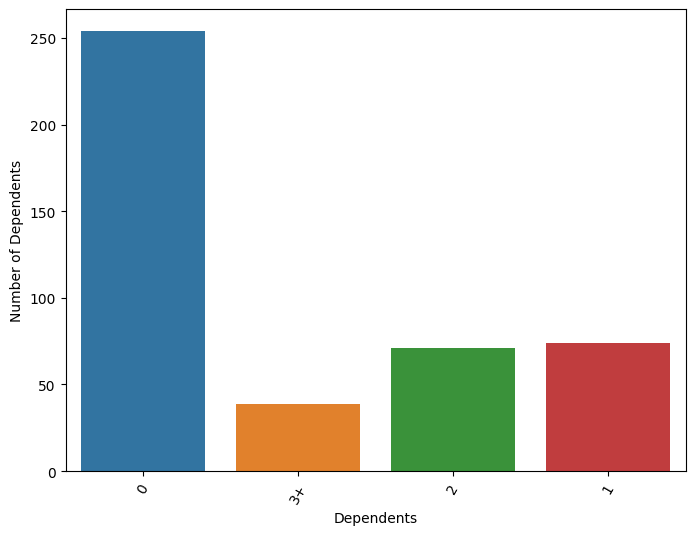

In [67]:
# Dependents

plt.figure(figsize=(8,6))
sns.countplot(x='Dependents', data=df_train)
plt.xlabel("Dependents")
plt.ylabel("Number of Dependents")
plt.xticks(rotation=60)
plt.show()

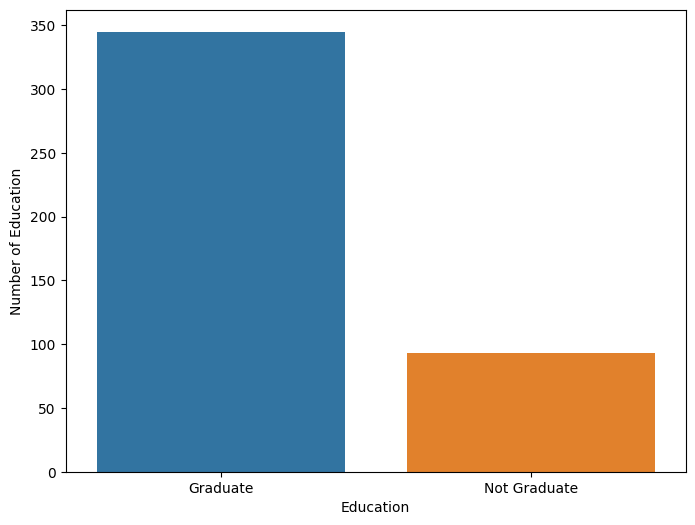

In [68]:
# Education
plt.figure(figsize=(8,6))
sns.countplot(x='Education', data=df_train)
plt.xlabel("Education")
plt.ylabel("Number of Education")
plt.yticks()
plt.show()

### Feature Engineering

In [69]:
df_test['Loan_Status'] = 999

# 合并处理
df_all = pd.concat([df_train, df_test], axis=0)

# 清理 Loan_ID
df_all.drop(columns=['Loan_ID'], inplace=True)

In [70]:
new_df = pd.get_dummies(df_all)

In [71]:
new_df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,4547,0.0,115.0,360.0,1.0,1,1,0,1,0,...,0,0,0,1,0,1,0,0,1,0
1,5703,0.0,130.0,360.0,1.0,1,0,1,0,1,...,0,0,1,0,1,0,1,1,0,0
2,4333,2451.0,110.0,360.0,1.0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,1
3,4695,0.0,96.0,360.0,1.0,1,0,1,0,1,...,0,0,0,0,1,0,1,0,0,1
4,6700,1750.0,230.0,300.0,1.0,1,0,1,0,1,...,0,1,0,1,0,1,0,0,1,0


In [95]:
new_df.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Gender_Female',
       'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_0',
       'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

In [72]:
# 分离 train 和 test

new_df['Loan_Status'].value_counts()

1      305
0      133
999    111
Name: Loan_Status, dtype: int64

In [73]:
# train

train_df = new_df[new_df['Loan_Status'].isin([0,1])].reset_index(drop=True)

train_df.shape

(438, 21)

In [74]:
train_df['Loan_Status'].value_counts()

1    305
0    133
Name: Loan_Status, dtype: int64

In [75]:
# test

test_df = new_df[new_df['Loan_Status'].isin([999])].reset_index(drop=True)

test_df.shape

(111, 21)

In [76]:
# 清理 test 中 Loan_Status 一列

test_df.drop(columns=['Loan_Status'], inplace=True)

test_df.shape

(111, 20)

In [77]:
# train_df 被切分为 train 和 eval

X = train_df.drop(columns=['Loan_Status'])
y = train_df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [78]:
X_train.shape

(350, 20)

In [79]:
X_test.shape

(88, 20)

### Model Training

In [80]:
# 模型定义
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False
)

In [81]:
# 定义参数
params = {
    'eta': np.arange(0.1, 0.3, 0.05).tolist(),
    'min_child_weight': np.arange(1, 5, 0.5).tolist(),
    'subsample': np.arange(0.5, 1.0, 0.1).tolist(),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1).tolist()
}

In [82]:
# 评估指标
scores = {
    'f1_score': make_scorer(f1_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [83]:
# K折验证
skf = KFold(n_splits=10, shuffle=True)

In [84]:
# 网格搜索 grid search CV
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    scoring=scores,
    n_jobs=-1,
    cv=skf.split(X_train, np.array(y_train)),
    refit='accuracy_score'
)

In [85]:
# 模型训练
grid.fit(X=X_train, y=y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x29d316970>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     int...
                         'eta': [0.1, 0.15000000000000002, 0.20000000000000004,
                                 0.25000000000000006],
                         'min_child_weight': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0,
                                              4.5],
                         'subsample': [0.5, 0.6, 0.7, 0.7999999999999999,
                                       0.8999999999999999]},
             refit='accuracy_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [89]:
# 最佳参数
print(grid.best_params_)

{'colsample_bytree': 0.5, 'eta': 0.1, 'min_child_weight': 4.5, 'subsample': 0.7}


In [87]:
# 预测
predicted = grid.predict(X_test)

In [90]:
# 计算评估指标

acc = accuracy_score(predicted, np.array(y_test))

print(acc)

0.8295454545454546


In [91]:
recall = recall_score(predicted, np.array(y_test))

print(recall)

0.8108108108108109


In [92]:
precision = precision_score(predicted, np.array(y_test))

print(precision)

0.9836065573770492


In [93]:
f1 = f1_score(predicted, np.array(y_test))

print(f1)

0.888888888888889


### save model

In [94]:
joblib.dump(grid.best_estimator_, '../bin/xgboostModel.pkl')

['../bin/xgboostModel.pkl']